## Simplest Introduction to Neural Networks with Keras

> This notebook is a part of [AI for Beginners Curricula](http://github.com/microsoft/ai-for-beginners). Visit the repository for complete set of learning materials.

### Neural Frameworks

There are several frameworks for training neural networks. However, if you want to get started fast and not go into much detail on how things work internally - you should consider using [Keras](https://keras.io/). This short tutorial will get you started, and if you want to get deeper into understanding how things work - look into [Introduction to Tensorflow and Keras](IntroKerasTF.ipynb) notebook.

### Getting things ready

Keras is a part of Tensorflow 2.x framework. Let's make sure we have version 2.x.x of Tensorflow installed:
```
pip install tensorflow
```
or
```
conda install tensorflow
```

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
print(f'Tensorflow version = {tf.__version__}')
# module 'keras.api._v2.keras' has no attribute '__version__'
# print(f'Keras version = {keras.__version__}')

Tensorflow version = 2.13.0


## Basic Concepts: Tensor

**Tensor** is a multi-dimensional array. It is very convenient to use tensors to represent different types of data:
* 400x400 - black-and-white picture
* 400x400x3 - color picture 
* 16x400x400x3 - minibatch of 16 color pictures
* 25x400x400x3 - one second of 25-fps video
* 8x25x400x400x3 - minibatch of 8 1-second videos

Tensors give us a convenient way to represent input/output data, as well we weights inside the neural network.

## Sample Problem

Let's consider binary classification problem. A good example of such a problem would be a tumour classification between malignant and benign based on it's size and age. Let's start by generating some sample data:


In [3]:
np.random.seed(0) # pick the seed for reproducibility - change it to explore the effects of random variations

n = 100
X, Y = make_classification(n_samples = n, n_features=2,
                           n_redundant=0, n_informative=2, flip_y=0.05,class_sep=1.5)
X = X.astype(np.float32)
Y = Y.astype(np.int32)

split = [ 70*n//100 ]
train_x, test_x = np.split(X, split)
train_labels, test_labels = np.split(Y, split)

In [4]:
def plot_dataset(features, labels, W=None, b=None):
    # prepare the plot
    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel('$x_i[0]$ -- (feature 1)')
    ax.set_ylabel('$x_i[1]$ -- (feature 2)')
    colors = ['r' if l else 'b' for l in labels]
    ax.scatter(features[:, 0], features[:, 1], marker='o', c=colors, s=100, alpha = 0.5)
    if W is not None:
        min_x = min(features[:,0])
        max_x = max(features[:,1])
        min_y = min(features[:,1])*(1-.1)
        max_y = max(features[:,1])*(1+.1)
        cx = np.array([min_x,max_x],dtype=np.float32)
        cy = (0.5-W[0]*cx-b)/W[1]
        ax.plot(cx,cy,'g')
        ax.set_ylim(min_y,max_y)
    fig.show()

C:\Users\liu\AppData\Local\Temp\ipykernel_20640\2721537645.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


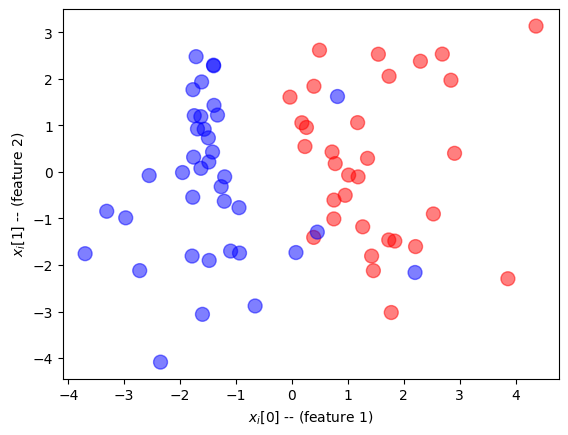

In [5]:
plot_dataset(train_x, train_labels)

## Normalizing Data

Before training, it is common to bring our input features to the standard range of [0,1] (or [-1,1]). The exact reasons for that we will discuss later in the course, but in short the reason is the following. We want to avoid values that flow through our network getting too big or too small, and we normally agree to keep all values in the small range close to 0. Thus we initialize the weights with small random numbers, and we keep signals in the same range.

When normalizing data, we need to subtract min value and divide by range. We compute min value and range using training data, and then normalize test/validation dataset using the same min/range values from the training set. This is because in real life we will only know the training set, and not all incoming new values that the network would be asked to predict. Occasionally, the new value may fall out of the [0,1] range, but that's not crucial.  

In [7]:
train_x_norm = (train_x-np.min(train_x,axis=0)) / (np.max(train_x,axis=0)-np.min(train_x,axis=0))
test_x_norm = (test_x-np.min(train_x,axis=0)) / (np.max(train_x,axis=0)-np.min(train_x,axis=0))

## Training One-Layer Network (Perceptron)

In many cases, a neural network would be a sequence of layers. It can be defined in Keras using `Sequential` model in the following manner:

In [8]:
model = keras.models.Sequential()
model.add(keras.Input(shape=(2,)))
model.add(keras.layers.Dense(1))
model.add(keras.layers.Activation(keras.activations.sigmoid))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 3         
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 3 (12.00 Byte)
Trainable params: 3 (12.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Here, we first create the model, and then add layers to it:
* First `Input` layer (which is not strictly speaking a layer) contains the specification of network's input size
* `Dense` layer is the actual perceptron that contains trainable weights
* Finally, there is a layer with *sigmoid* `Activation` function to bring the result of the network into 0-1 range (to make it a probability).

Input size, as well as activation function, can also be specified directly in the `Dense` layer for brevity: 

In [9]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(1,input_shape=(2,),activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 3 (12.00 Byte)
Trainable params: 3 (12.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Before training the model, we need to **compile it**, which essentially mean specifying:
* **Loss function**, which defines how loss is calculated. Because we have two-class classification problem, we will use *binary cross-entropy loss*.
* **Optimizer** to use. The simplest option would be to use `sgd` for *stochastic gradient descent*, or you can use more sophisticated optimizers such as `adam`.
* **Metrics** that we want to use to measure success of our training. Since it is classification task, a good metrics would be `Accuracy` (or `acc` for short)

We can specify loss, metrics and optimizer either as strings, or by providing some objects from Keras framework. In our example, we need to specify `learning_rate` parameter to fine-tune learning speed of our model, and thus we provide full name of Keras SGD optimizer.

In [10]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.2),loss='binary_crossentropy',metrics=['acc'])

After compiling the model, we can do the actual training by calling `fit` method. The most important parameters are:
* `x` and `y` specify training data, features and labels respectively
* If we want validation to be performed on each epoch, we can specify `validation_data` parameter, which would be a tuple of features and labels
* `epochs` specified the number of epochs
* If we want training to happen in minibatches, we can specify `batch_size` parameter. You can also pre-batch the data manually before passing it to `x`/`y`/`validation_data`, in which case you do not need `batch_size`

In [11]:
model.fit(x=train_x_norm,y=train_labels,validation_data=(test_x_norm,test_labels),epochs=10,batch_size=1)

Epoch 1/10
70/70 [==============================] - 1s 7ms/step - loss: 0.7298 - acc: 0.5286 - val_loss: 0.6521 - val_acc: 0.5333
Epoch 2/10
70/70 [==============================] - 0s 2ms/step - loss: 0.6461 - acc: 0.6429 - val_loss: 0.5862 - val_acc: 0.9333
Epoch 3/10
70/70 [==============================] - 0s 2ms/step - loss: 0.5691 - acc: 0.7857 - val_loss: 0.5300 - val_acc: 0.9333
Epoch 4/10
70/70 [==============================] - 0s 2ms/step - loss: 0.5244 - acc: 0.8714 - val_loss: 0.5057 - val_acc: 0.8333
Epoch 5/10
70/70 [==============================] - 0s 2ms/step - loss: 0.4861 - acc: 0.9000 - val_loss: 0.4693 - val_acc: 0.8667
Epoch 6/10
70/70 [==============================] - 0s 2ms/step - loss: 0.4501 - acc: 0.9000 - val_loss: 0.4498 - val_acc: 0.8333
Epoch 7/10
70/70 [==============================] - 0s 2ms/step - loss: 0.4152 - acc: 0.9143 - val_loss: 0.4016 - val_acc: 0.9667
Epoch 8/10
70/70 [==============================] - 0s 2ms/step - loss: 0.4048 - acc: 0.90

You can try to experiment with different training parameters to see how they affect the training:
* Setting `batch_size` to be too large (or not specifying it at all) may result in less stable training, because with low-dimensional data small batch sizes provide more precise direction of the gradient for each specific case
* Too high `learning_rate` may result in overfitting, or in less stable results, while too low learning rate means it will take more epochs to achieve the result

> Note that you can call `fit` function several times in a row to further train the network. If you want to start training from scratch - you need to re-run the cell with the model definition. 

To make sure our training worked, let's plot the line that separates two classes. Separation line is defined by the equation $W\times x + b = 0.5$

C:\Users\liu\AppData\Local\Temp\ipykernel_20640\2721537645.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


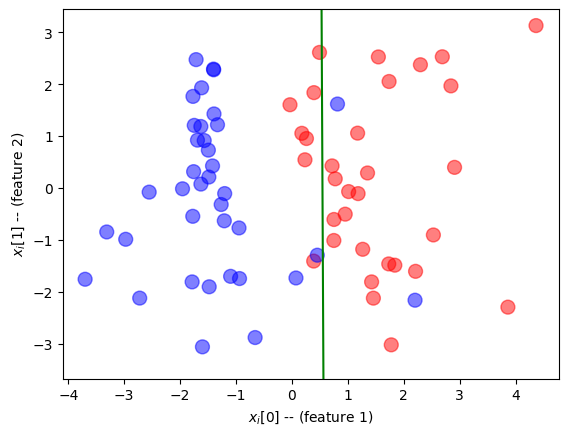

In [12]:
plot_dataset(train_x,train_labels,model.layers[0].weights[0],model.layers[0].weights[1])

## Plotting the training graphs

`fit` function returns `history` object as a result, which can be used to observe loss and metrics on each epoch. In the example below, we will re-start the training with small learning rate, and will observe how the loss and accuracy behave.

> **Note** that we are using slightly different syntax for defining `Sequential` model. Instead of `add`-ing layers one by one, we can also specify the list of layers right when creating the model in the first place - this is a bit shorter syntax, and you may prefer to use it.

In [13]:
model = keras.models.Sequential([
    keras.layers.Dense(1,input_shape=(2,),activation='sigmoid')])
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.05),loss='binary_crossentropy',metrics=['acc'])
hist = model.fit(x=train_x_norm,y=train_labels,validation_data=(test_x_norm,test_labels),epochs=10,batch_size=1)

Epoch 1/10
70/70 [==============================] - 1s 3ms/step - loss: 0.6897 - acc: 0.5143 - val_loss: 0.6688 - val_acc: 0.6667
Epoch 2/10
70/70 [==============================] - 0s 3ms/step - loss: 0.6481 - acc: 0.6857 - val_loss: 0.6665 - val_acc: 0.5667
Epoch 3/10
70/70 [==============================] - 0s 2ms/step - loss: 0.6355 - acc: 0.7429 - val_loss: 0.6425 - val_acc: 0.6000
Epoch 4/10
70/70 [==============================] - 0s 3ms/step - loss: 0.6156 - acc: 0.7714 - val_loss: 0.6206 - val_acc: 0.7667
Epoch 5/10
70/70 [==============================] - 0s 3ms/step - loss: 0.5947 - acc: 0.8000 - val_loss: 0.5969 - val_acc: 0.9000
Epoch 6/10
70/70 [==============================] - 0s 3ms/step - loss: 0.5811 - acc: 0.9429 - val_loss: 0.5848 - val_acc: 0.8667
Epoch 7/10
70/70 [==============================] - 0s 3ms/step - loss: 0.5652 - acc: 0.9286 - val_loss: 0.5681 - val_acc: 0.9000
Epoch 8/10
70/70 [==============================] - 0s 3ms/step - loss: 0.5510 - acc: 0.94

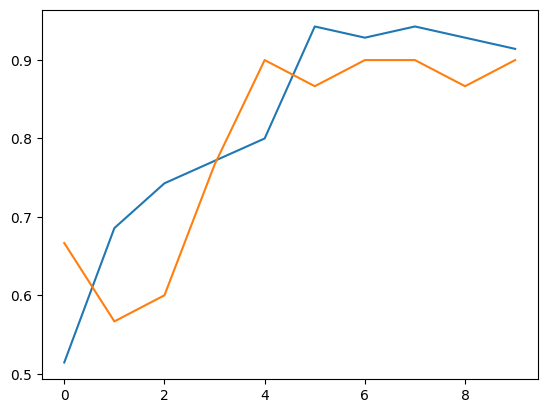

In [14]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

## Multi-Class Classification

If you need to solve a problem of multi-class classification, your network would have more that one output - corresponding to the number of classes $C$. Each output will contain the probability of a given class.

> Note that you can also use a network with two outputs to perform binary classification in the same manner. That is exactly what we will demonstrate now.

When you expect a network to output a set of probabilities $p_1,\dots, p_C$, we need all of them to add up to 1. To ensure this, we use `softmax` as a final activation function on the last layer. **Softmax** takes a vector input, and makes sure that all components of that vector are transformed into probabilities.

Also, since the output of the network is a $C$-dimensional vector, we need labels to have the same form. This can be achieved by using **one-hot encoding**, when the number of a class $i$ is converted to a vector of zeroes, with 1 at the $i$-th position.

To compare the probability output of the neural network with expected one-hot-encoded label, we use **cross-entropy loss** function. It takes two probability distributions, and outputs a value of how different they are.

So, to summarize what we need to do for multi-class classification with $C$ classes:
* The network should have $C$ neurons in the last layer
* Last activation function should be **softmax**
* Loss should be **cross-entropy loss**
* Labels should be converted to **one-hot encoding** (this can be done using `numpy`, or using Keras utils `to_categorical`)

In [16]:
model = keras.models.Sequential([
    keras.layers.Dense(5,input_shape=(2,),activation='relu'),
    keras.layers.Dense(2,activation='softmax')
])
model.compile(keras.optimizers.Adam(0.01),'categorical_crossentropy',['acc'])

# Two ways to convert to one-hot encoding
train_labels_onehot = keras.utils.to_categorical(train_labels)
test_labels_onehot = np.eye(2)[test_labels]

hist = model.fit(x=train_x_norm,y=train_labels_onehot,
                 validation_data=[test_x_norm,test_labels_onehot],batch_size=1,epochs=10)

Epoch 1/10
70/70 [==============================] - 0s 2ms/step - loss: 0.7282 - acc: 0.5143 - val_loss: 0.7034 - val_acc: 0.4667
Epoch 2/10
70/70 [==============================] - 0s 1ms/step - loss: 0.6601 - acc: 0.6429 - val_loss: 0.6406 - val_acc: 0.7000
Epoch 3/10
70/70 [==============================] - 0s 1ms/step - loss: 0.6078 - acc: 0.7286 - val_loss: 0.5908 - val_acc: 0.8000
Epoch 4/10
70/70 [==============================] - 0s 1ms/step - loss: 0.5497 - acc: 0.8429 - val_loss: 0.5592 - val_acc: 0.7667
Epoch 5/10
70/70 [==============================] - 0s 1ms/step - loss: 0.4880 - acc: 0.9000 - val_loss: 0.4381 - val_acc: 0.9000
Epoch 6/10
70/70 [==============================] - 0s 1ms/step - loss: 0.4198 - acc: 0.9000 - val_loss: 0.3759 - val_acc: 0.9667
Epoch 7/10
70/70 [==============================] - 0s 1ms/step - loss: 0.3800 - acc: 0.9429 - val_loss: 0.3391 - val_acc: 0.9000
Epoch 8/10
70/70 [==============================] - 0s 1ms/step - loss: 0.3389 - acc: 0.92

### Sparse Categorical Cross-Entropy

Often labels in multi-class classification are represented by class numbers. Keras also supports another kind of loss function called **sparse categorical crossentropy**, which expects class number to be integers, and not one-hot vectors. Using this kind of loss function, we can simplify our training code:

In [17]:
model.compile(keras.optimizers.Adam(0.01),'sparse_categorical_crossentropy',['acc'])
model.fit(x=train_x_norm,y=train_labels,validation_data=[test_x_norm,test_labels],batch_size=1,epochs=10)

Epoch 1/10
70/70 [==============================] - 0s 2ms/step - loss: 0.2714 - acc: 0.9429 - val_loss: 0.2682 - val_acc: 0.9000
Epoch 2/10
70/70 [==============================] - 0s 1ms/step - loss: 0.2521 - acc: 0.9429 - val_loss: 0.2233 - val_acc: 0.9333
Epoch 3/10
70/70 [==============================] - 0s 1ms/step - loss: 0.2582 - acc: 0.9571 - val_loss: 0.2508 - val_acc: 0.9000
Epoch 4/10
70/70 [==============================] - 0s 1ms/step - loss: 0.2399 - acc: 0.9143 - val_loss: 0.2145 - val_acc: 0.9000
Epoch 5/10
70/70 [==============================] - 0s 1ms/step - loss: 0.2755 - acc: 0.9000 - val_loss: 0.2322 - val_acc: 0.9000
Epoch 6/10
70/70 [==============================] - 0s 1ms/step - loss: 0.2371 - acc: 0.9429 - val_loss: 0.2048 - val_acc: 0.9000
Epoch 7/10
70/70 [==============================] - 0s 1ms/step - loss: 0.2238 - acc: 0.9571 - val_loss: 0.1873 - val_acc: 0.9667
Epoch 8/10
70/70 [==============================] - 0s 1ms/step - loss: 0.2525 - acc: 0.95

## Multi-Label Classification

Sometime we have cases when our objects can belong to two classes at once. As an example, suppose we want to develop a classifier for cats and dogs on the picture, but we also want to allow cases when both cats and dogs are present.

With multi-label classification, instead of one-hot encoded vector, we will have a vector that has 1 in position corresponding to all classes relevant to the input sample. Thus, output of the network should not have normalized probabilities for all classes, but rather for each class individually - which corresponds to using **sigmoid** activation function. Cross-entropy loss can still be used as a loss function.

> **Note** that this is very similar to using **different neural networks** to do binary classification for each particular class - only the initial part of the network (up to final classification layer) is shared for all classes.

## Summary of Classification Loss Functions

We have seen that binary, multi-class and multi-label classification differ by the type of loss function and activation function on the last layer of the network. It may all be a little bit confusing if you are just starting to learn, but here are a few rules to keep in mind:
* If the network has one output (**binary classification**), we use **sigmoid** activation function, for **multiclass classification** - **softmax**
* If the output class is represented as one-hot-encoding, the loss function will be **cross entropy loss** (categorical cross-entropy), if the output contains class number - **sparse categorical cross-entropy**.  For **binary classification** - use **binary cross-entropy** (same as **log loss**)
* **Multi-label classification** is when we can have an object belonging to several classes at the same time. In this case, we need to encode labels using one-hot encoding, and use **sigmoid** as activation function, so that each class probability is between 0 and 1.

| Classification | Label Format | Activation Function | Loss |
|---------------|-----------------------|-----------------|----------|
| Binary      | Probability of 1st class | sigmoid | binary crossentropy |
| Binary      | One-hot encoding (2 outputs) | softmax | categorical crossentropy |
| Multiclass |  One-hot encoding | softmax | categorical crossentropy |
| Multiclass | Class Number | softmax | sparse categorical crossentropy |
| Multilabel | One-hot encoding | sigmoid | categorical crossentropy |


**Task**: 
Use Keras to train a classifier for MNIST handwritten digits:
* Notice that Keras contains some standard datasets, including MNIST. To use MNIST from Keras, you only need a couple of lines of code (more information [here](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist))
* Try several network configuration, with different number of layers/neurons, activation functions.

What is the best accuracy you were able to achieve?

In [21]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1,28*28).astype(np.float32)/255
x_test = x_test.reshape(-1,28*28).astype(np.float32)/255

model = keras.models.Sequential([
    keras.layers.Dense(20,input_shape=(28*28,),activation='relu'),
    keras.layers.Dense(10,activation='softmax')
])
model.compile(keras.optimizers.Adam(0.01),'categorical_crossentropy',['acc'])

# Two ways to convert to one-hot encoding
train_labels_onehot = keras.utils.to_categorical(y_train)
test_labels_onehot = np.eye(10)[y_test]

hist = model.fit(x=x_train,y=train_labels_onehot,
                 validation_data=[x_test,test_labels_onehot],batch_size=1,epochs=10)

Epoch 1/10
60000/60000 [==============================] - 41s 688us/step - loss: 0.6817 - acc: 0.8297 - val_loss: 0.5704 - val_acc: 0.8727
Epoch 2/10
60000/60000 [==============================] - 41s 691us/step - loss: 0.6531 - acc: 0.8526 - val_loss: 0.6240 - val_acc: 0.8790
Epoch 3/10
60000/60000 [==============================] - 42s 701us/step - loss: 0.6366 - acc: 0.8652 - val_loss: 0.6346 - val_acc: 0.8959
Epoch 4/10
60000/60000 [==============================] - 40s 665us/step - loss: 0.6479 - acc: 0.8661 - val_loss: 0.6033 - val_acc: 0.8861
Epoch 5/10
60000/60000 [==============================] - 41s 683us/step - loss: 0.6677 - acc: 0.8692 - val_loss: 0.7052 - val_acc: 0.8760
Epoch 6/10
60000/60000 [==============================] - 41s 689us/step - loss: 0.6738 - acc: 0.8647 - val_loss: 0.8380 - val_acc: 0.8736
Epoch 7/10
60000/60000 [==============================] - 41s 682us/step - loss: 0.6801 - acc: 0.8598 - val_loss: 0.6650 - val_acc: 0.8742
Epoch 8/10
60000/60000 [===

## Takeaways

* **Keras** is really recommended for beginners, because it allows to construct networks from layers quite easily, and then train it with just a couple of lines of code
* If non-standard architecture is needed, you would need to learn a bit deeper into Tensorflow. Or you can ask someone to implement custom logic as a Keras layer, and then use it in Keras models
* It is a good idea to look at PyTorch as well and compare approaches. 

A good sample notebook from the creator of Keras on Keras and Tensorflow 2.0 can be found [here](https://t.co/k694J95PI8).